In [23]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import sys
from sklearn.cross_validation import cross_val_predict
from sklearn.cross_validation import cross_val_score

from sklearn.pipeline import Pipeline

# basic natural language feature extraction
import sklearn.feature_extraction.text as fet

# used for train/test splits and cross validation
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV

# used to impute mean for data and standardize for computational stability
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

# logistic regression is our favourite model ever
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV

# used to calculate AUROC/accuracy
from sklearn import metrics

# used to create confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import cross_val_score

# gradient boosting - must download package https://github.com/dmlc/xgboost
#import xgboost as xgb

# default colours for prettier plots

col = [[0.9047, 0.1918, 0.1988],
    [0.2941, 0.5447, 0.7494],
    [0.3718, 0.7176, 0.3612],
    [1.0000, 0.5482, 0.1000],
    [0.4550, 0.4946, 0.4722],
    [0.6859, 0.4035, 0.2412],
    [0.9718, 0.5553, 0.7741],
    [0.5313, 0.3359, 0.6523]];
marker = ['v','o','d','^','s','o','+']
ls = ['-','-','-','-','-','s','--','--']
%matplotlib inline

from __future__ import print_function

In [4]:
# read data from the got-data.ipynb file
# most of it is scrapped from the game of thrones tv show wiki
df = pd.read_csv('data/got_data_valid_characters.csv', sep=',', index_col=0)

# print out the data we have
print('Total of {} characters.'.format(df.shape[0]))
df.head(n=3)

Total of 185 characters.


,Age,Allegiance,Also known as,Appeared in,Culture,Date of birth,Death,Family,First seen,Last seen,...,Religion,Season(s),Status,Titles,Background,Season 1,Season 2,Season 3,Season 4,Season 5
Aemon,104[1],Night's Watch (by oath)Order of Maesters (by o...,Aemon Targaryen (formerly)Maester Aemon,11 episodes (see below),NaN,NaN,Died peacefully in his bed from old age,{Maekar I Targaryen} - father{Dyanna Dayne} - ...,"""Lord Snow""","""The Gift""",...,NaN,"1, 3, 4, 5",Deceased,"MaesterPrince (formerly, decades ago)",Aemon has served as the maester of Castle Bla...,After Tyrion Lannister has arrived at Castle ...,NaN,Aemon with Samwell Tarly and Gilly at Castle ...,Aemon with Alliser and Janos during Jon's jud...,Maester Aemon presides over the choosing of t...
Alliser_Thorne,NaN,The Night's WatchHouse Thorne (by birth),NaN,17 episodes (see below),NaN,NaN,NaN,NaN,"""Lord Snow""",NaN,...,NaN,"1, 4, 5, 6",Alive,SerMaster-at-Arms at Castle BlackLord Commande...,Ser Alliser Thorne is a member of the Night's...,Thorne sets Jon Snow against his fellow recru...,NaN,NaN,"Upon his return to the Wall, Thorne has been ...",Alliser Thorne has recovered from the wounds ...
Areo_Hotah,NaN,House Martell,NaN,6 episodes (see below),Norvos,NaN,Stabbed in the back by Tyene Sand,NaN,"""The House of Black and White""","""The Red Woman""",...,NaN,"5, 6",Deceased,Captain of the Guard,"Areo Hotah is originally from Norvos, one of ...",NaN,NaN,NaN,NaN,Areo Hotah blocks Ellaria's passage to Prince...


```python
# define a matrix of relationships ... realized this is harder than it looks!
# 0 - not related
# 1 - father
# 2 - mother
# 3 - sibling
# 4 - child
# 5 - other
fam = pd.DataFrame(np.zeros([df.shape[0],df.shape[0]]), index=df.index, columns=df.index)
for i, char in enumerate(fam.index):
    curr_fam = df.loc[char, 'Family']
    if curr_fam is np.nan or curr_fam is None:
        continue
    
    # otherwise, let's parse their family tree
    common_fam = [filter(lambda x: x in curr_fam, sublist) for sublist in fam.index]
    print(curr_fam)
    #print(common_fam)
    break
```

In [5]:
# define some useful subfunctions

# given a dataframe/regex phrase, this counts the number of times the regex appears
def count_words(s, phrase):
    if s is np.nan:
        return 0
    else:
        return len(re.findall(phrase,s, re.IGNORECASE))

# this calls the above function and adds the data to the given dataframe
def add_data(df_data, column_name, phrase, txt_col=None):
    if txt_col is None:
        txt_col = ['Background','Season 1','Season 2', 'Season 3', 'Season 4']
        
    df_new = df[txt_col].applymap(lambda x: count_words(x,phrase))
    df_data[column_name] = df_new[txt_col].sum(axis=1)
    return df_data

def add_allegiance(df, df_has_allegiance):
    
    houses = ['House Lannister', 'House Stark', 'House Targaryen', 'House Frey', 
              'House Greyjoy', "Night's Watch", 'House Martell', 'Free Folk', 'House Forrester',
              'House Bolton', 'House Baratheon', 'Kingsguard']
    
    for h in houses:
        tmp = np.zeros(df.shape[0])
        val = df_has_allegiance['Allegiance'].values
        for i in range(df.shape[0]):
            if val[i] is np.nan:
                continue
            elif h in val[i]:
                tmp[i] = 1.0
        df[h] = tmp
        
    return df

In [6]:
def extract_data(df, s=3):
    # given the dataframe and the season, extract some features
    # only look at background // season 1
    
    # by default, extract data up to and including season 3, i.e. s=3
    txt_col = ['Background','Season 1','Season 2','Season 3','Season 4',' Season 5']
    
    txt_col = txt_col[0:(s+1)]
    
    # initialize the dataframe
    idxData = np.ones(df.shape[0], dtype=bool)
    df_data = df.loc[idxData, ['Status','Season(s)']]

    # start adding data based on counting the frequency of words

    # count the number of hyphens as a surrogate as the number of in-show family member
    # in the data, the family members appear as "sister - Sansa Stark, father - Eddard Stark," .. etc
    df_data = add_data(df_data, 'family_members',' - ', txt_col = ['Family'])

    #df_data = add_allegiance(df_data, df)
    
    # number of seasons the character appeared in
    df_data = add_data(df_data, 'number_of_seasons','[1-' + str(s) + ']', txt_col = ['Season(s)'])

    # various word "types" across all the data
    df_data = add_data(df_data, 'violent_words','(knight|warrior|sword|axe|spear|kill|murder|fight|assassinate)')
    df_data = add_data(df_data, 'sexy_words','(sex|naked|love|slept|nude|kiss)')
    df_data = add_data(df_data, 'fun_words','(beer|wine|glass|drunk|inebriate)')
    df_data = add_data(df_data, 'number_of_words','\w+')

    # remove people who died before current season
    idxRemove = np.zeros(df_data.shape[0],dtype=bool)
    for i, val in enumerate(df_data['Status'].values):
        char = df_data.index[i]
        if val is None or val is np.nan:
            continue
        if ('Dead' in val) | ('Deceased' in val):
            if len(re.findall('[' + str(s+1) + '-5]', df_data.loc[char, 'Season(s)'])) > 0:
                continue
            else:
                idxRemove[i] = True

    df_data = df_data.loc[~idxRemove]

    df_data.drop('Season(s)',axis=1,inplace=True)
    return df_data
    

In [7]:
df_data = extract_data(df, s=4)
df_data.head(n=2)

,Status,family_members,number_of_seasons,violent_words,sexy_words,fun_words,number_of_words
Aemon,Deceased,12,3,2,2,0,1301
Alliser_Thorne,Alive,0,2,12,1,1,1426


lr         0.536812 [ 0.25, 0.73913]


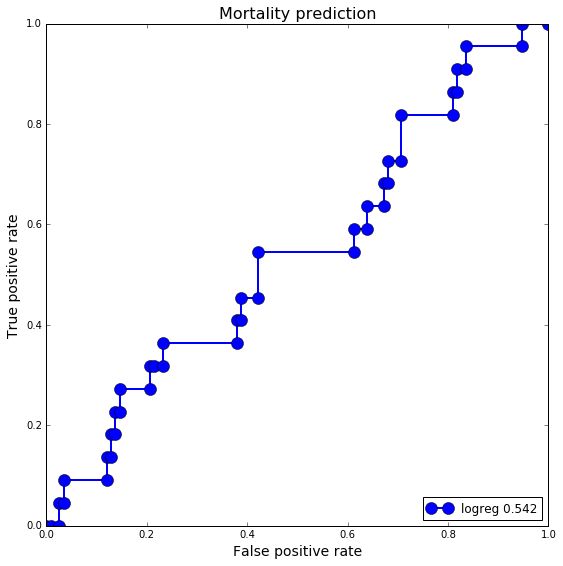

In [8]:
# prep data
X = df_data.values[:,1:df_data.shape[1]]

# alive until proven dead !
y = np.zeros(df_data.shape[0])
for i, val in enumerate(df_data['Status'].values):
    if val is None or val is np.nan:
        continue
    if 'Dead' in val:
        y[i] = 1.0
    elif 'Deceased' in val:
        y[i] = 1.0
        
# workaround cross_val_predict returning 0s/1s - calling this makes it return probabilities
class proba_logreg(LogisticRegression):
    def predict(self, X):
        return LogisticRegression.predict_proba(self, X)

# cross-validation performance
mdl = "logreg"
model = LogisticRegression(fit_intercept=True)
estimator = Pipeline([("imputer", Imputer(missing_values='NaN',
                                      strategy="mean",
                                      axis=0)),
                  ("scaler", StandardScaler()),
                  ("lr", model)])
scores = cross_val_score(estimator, X, y, scoring='roc_auc',cv=5)
print('{:10s} {:5g} [{:5g}, {:5g}]'.format("lr", np.mean(scores), np.min(scores), np.max(scores) ))

# plot a roc curve by getting cross-validation predictions
predicted = cross_val_predict(proba_logreg(), X, y, cv=10)
predicted = predicted[:,1]

plt.figure(figsize=[9,9])
ax = plt.gca()
fpr, tpr, thresholds = metrics.roc_curve(y, predicted, pos_label=1)
plt.plot(fpr, tpr, 'bo-',lw=2,markersize=12,
        label=mdl + ' ' + '%0.3f' % metrics.auc(fpr, tpr))
plt.xlabel('False positive rate',fontsize=14)
plt.ylabel('True positive rate',fontsize=14)
plt.legend(loc='lower right')
plt.title('Mortality prediction',fontsize=16)
plt.show()

In [9]:
sort_indices = np.argsort(predicted)

for i in range(20):
    idx = sort_indices[-i-1]
    print('{:20s}: {:0.5f} (outcome: {})'.format(df_data.index[idx],
                                        predicted[idx],
                                       y[idx]))

Nymeria_Sand        : 0.44362 (outcome: 0.0)
Walder_Frey         : 0.44311 (outcome: 0.0)
Lancel              : 0.43200 (outcome: 0.0)
Shireen_Baratheon   : 0.40623 (outcome: 1.0)
Obara_Sand          : 0.40508 (outcome: 0.0)
Steffon_Baratheon   : 0.40018 (outcome: 1.0)
Tyene_Sand          : 0.39454 (outcome: 0.0)
Podrick_Payne       : 0.34880 (outcome: 0.0)
Willas_Tyrell       : 0.33750 (outcome: 0.0)
Rickon_Stark        : 0.33383 (outcome: 0.0)
Edmure_Tully        : 0.31655 (outcome: 0.0)
Robin_Arryn         : 0.31235 (outcome: 0.0)
Trystane_Martell    : 0.31096 (outcome: 0.0)
Daario_Naharis      : 0.31065 (outcome: 0.0)
Benjen_Stark        : 0.30714 (outcome: 0.0)
Walda_Bolton        : 0.30200 (outcome: 0.0)
Rickard_Stark       : 0.29922 (outcome: 1.0)
Lothar_Frey         : 0.29087 (outcome: 0.0)
Elia_Martell        : 0.28288 (outcome: 1.0)
Sansa_Stark         : 0.28271 (outcome: 0.0)


# TF-IDF

Let's try TF-IDF of the same data !

In [16]:
def extract_data_text(df, s=3):
    # given the dataframe and the season, extract some features
    # only look at background // season 1
    
    # by default, extract data up to and including season 3, i.e. s=3
    txt_col = ['Background','Season 1','Season 2','Season 3','Season 4',' Season 5']
    
    txt_col = txt_col[0:(s+1)]
    
    # initialize the dataframe
    idxData = np.ones(df.shape[0], dtype=bool)
    df_data = df.loc[idxData, ['Status','Season(s)']]

    # === ADD DATA === #

    tmp = None
    for txt in txt_col:
        if tmp is None:
            tmp = df[txt]
        else:
            tmp = tmp.str.cat(df[txt].fillna('') , sep='\n')

    df_data['text'] = tmp.fillna('')
    
    # remove people who died before current season
    idxRemove = np.zeros(df_data.shape[0],dtype=bool)
    for i, val in enumerate(df_data['Status'].values):
        char = df_data.index[i]
        if val is None or val is np.nan:
            continue
        if ('Dead' in val) | ('Deceased' in val):
            if len(re.findall('[' + str(s+1) + '-5]', df_data.loc[char, 'Season(s)'])) > 0:
                continue
            else:
                idxRemove[i] = True

    df_data = df_data.loc[~idxRemove]
    
    # now we have the data frame ... get X and y matrices
    X = df_data['text'].values

    # alive until proven dead !
    y = np.zeros(df_data.shape[0])
    for i, val in enumerate(df_data['Status'].values):
        if val is None or val is np.nan:
            continue
        # check if they have any seasons after the next one
        # this is to confirm that, if they died, they died in the next season
        if len(re.findall('[' + str(s+2) + '-' + str(np.max([s+2,5])) + ']',
                          df_data.iloc[i]['Season(s)'])) == 0:
            if 'Dead' in val:
                y[i] = 1.0
            elif 'Deceased' in val:
                y[i] = 1.0
        
    #print('Died in season {}'.format(s+1))
    #for i,val in enumerate(y):
    #    if val==1.0:
    #        print('{}'.format(df_data.index[i]))
    return X, y

In [17]:
X, y = extract_data_text(df, s=3)

In [21]:
tf = fet.TfidfVectorizer(analyzer='word', ngram_range=(1,3), min_df = 0, stop_words = 'english')
tfidf_matrix =  tf.fit_transform(X)
feature_names = tf.get_feature_names()
print('Example phrases:')
for i in range(5):
    print(feature_names[i+50])


print('\n' + 'Shape of the design matrix: ' + '{}'.format(tfidf_matrix.shape))

Example phrases:
200 northmen rivermen
200 ships
200 ships joffrey
30
30 ships

Shape of the design matrix: (154, 99960)


In [28]:
tf = fet.TfidfVectorizer(analyzer='word', ngram_range=(1,3), min_df = 0, stop_words = 'english')
mdl = LassoCV(cv=5,fit_intercept=True)


pipeline = Pipeline([
    ('tfidf', tf),
    ('clf', mdl),
])

scores = cross_val_score(pipeline, X, y, scoring='roc_auc')

In [29]:
np.mean(scores)

0.61294142980189492